In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             roc_auc_score, confusion_matrix, roc_curve, 
                             precision_recall_curve, f1_score)
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')

In [21]:
data = pd.read_csv("../data/raw/employee_data.csv")


In [22]:
data.columns

Index(['employee_id', 'age', 'gender', 'marital_status', 'salary',
       'employment_type', 'region', 'has_dependents', 'tenure_years',
       'enrolled'],
      dtype='str')

In [23]:
# preparing data for modeling
features = ['has_dependents', 'employment_type', 'age', 'salary']
X = data[features] 
y = data['enrolled']

In [25]:
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print("Categorical features:", categorical_features)
print("Numerical features:", numeric_features)

Categorical features: ['has_dependents', 'employment_type']
Numerical features: ['age', 'salary']


In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f"Train: {len(X_train)},Test: {len(X_test)}")

Train: 8000,Test: 2000


In [27]:
def create_pipeline():
    """Create Logistic Regression pipeline with one-hot encoding and scaling."""
    preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ])
    
    return Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])

In [28]:
# Cross-validation
cv_scores = cross_val_score(create_pipeline(), X_train, y_train, cv=5, scoring='roc_auc')
print(f"CV ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

CV ROC-AUC: 0.9667 (+/- 0.0059)


In [ ]:
# Hyperparameter tuning
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'], 
    'classifier__solver': ['lbfgs', 'liblinear'] #  Logistic Regression solvers that support L2 regularization
}

grid = GridSearchCV(create_pipeline(), param_grid, cv=5, scoring='roc_auc')
grid.fit(X_train, y_train)

print(f"\nBest params: {grid.best_params_}")
print(f"Best CV score: {grid.best_score_:.4f}")


Best params: {'classifier__C': 1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best CV score: 0.9667


In [30]:
# Evaluate model
model = grid.best_estimator_
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
y_train_prob = model.predict_proba(X_train)[:, 1]
y_test_prob = model.predict_proba(X_test)[:, 1]

print("\nPerformance Metrics:")
print(f"Train AUC: {roc_auc_score(y_train, y_train_prob):.4f}")
print(f"Test AUC:  {roc_auc_score(y_test, y_test_prob):.4f}")
print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Test Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Test Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"Test F1: {f1_score(y_test, y_test_pred):.4f}")


Performance Metrics:
Train AUC: 0.9669
Test AUC:  0.9705
Test Accuracy: 0.8965
Test Precision: 0.9099
Test Recall: 0.9239
Test F1: 0.9168


In [31]:
# Check overfitting
auc_diff = roc_auc_score(y_train, y_train_prob) - roc_auc_score(y_test, y_test_prob)
if auc_diff > 0.05:
    print(f"\n⚠️  Warning: Train-Test AUC gap = {auc_diff:.4f}")


In [32]:
# Feature importance (coefficients)
preprocessor = model.named_steps['preprocessor']
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_features = list(cat_features) + numeric_features
coefficients = model.named_steps['classifier'].coef_[0]

feature_importance = pd.DataFrame({
    'feature': all_features,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

print("\nFeature Coefficients:")
print(feature_importance[['feature', 'coefficient']])



Feature Coefficients:
                     feature  coefficient
1  employment_type_Full-time     5.361328
0         has_dependents_Yes     5.298509
4                     salary     2.373402
3                        age     1.681765
2  employment_type_Part-time    -0.143187


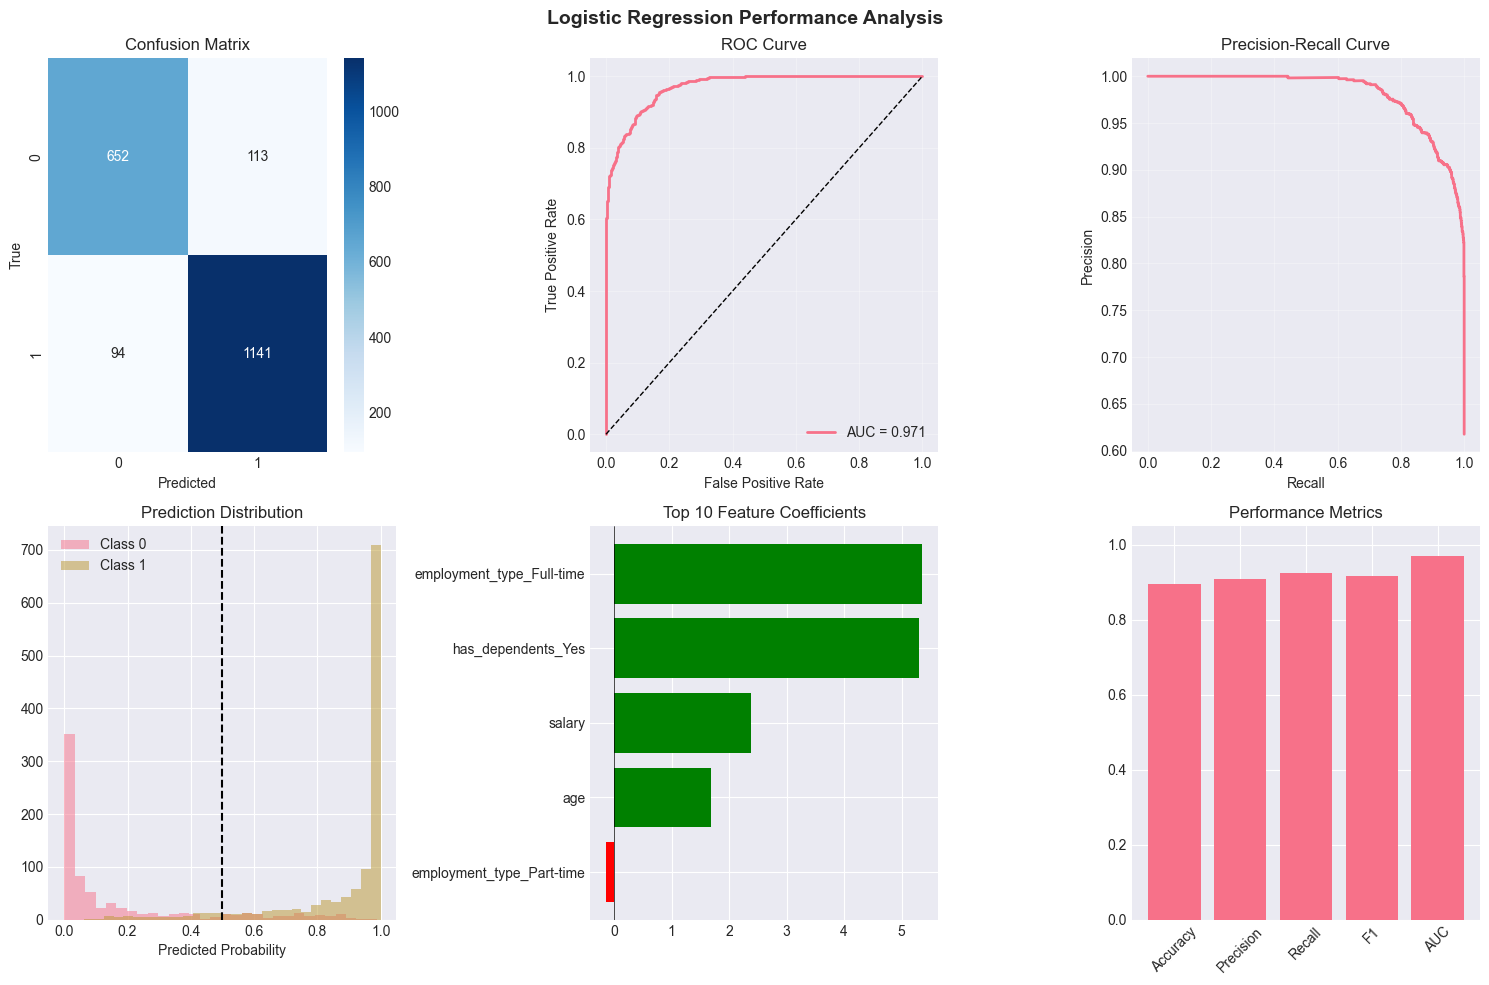

In [33]:
# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Logistic Regression Performance Analysis', fontsize=14, fontweight='bold')

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
axes[0,0].set_title('Confusion Matrix')
axes[0,0].set_ylabel('True')
axes[0,0].set_xlabel('Predicted')

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_test_prob)
axes[0,1].plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc_score(y_test, y_test_prob):.3f}')
axes[0,1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[0,1].set_title('ROC Curve')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].legend()
axes[0,1].grid(alpha=0.3)

# Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_test, y_test_prob)
axes[0,2].plot(rec, prec, lw=2)
axes[0,2].set_title('Precision-Recall Curve')
axes[0,2].set_xlabel('Recall')
axes[0,2].set_ylabel('Precision')
axes[0,2].grid(alpha=0.3)

# Prediction distribution
axes[1,0].hist(y_test_prob[y_test==0], bins=30, alpha=0.5, label='Class 0')
axes[1,0].hist(y_test_prob[y_test==1], bins=30, alpha=0.5, label='Class 1')
axes[1,0].axvline(0.5, color='k', linestyle='--')
axes[1,0].set_title('Prediction Distribution')
axes[1,0].set_xlabel('Predicted Probability')
axes[1,0].legend()

# Feature coefficients
top_features = feature_importance.head(10)
colors = ['green' if x > 0 else 'red' for x in top_features['coefficient']]
axes[1,1].barh(range(len(top_features)), top_features['coefficient'], color=colors)
axes[1,1].set_yticks(range(len(top_features)))
axes[1,1].set_yticklabels(top_features['feature'])
axes[1,1].set_title('Top 10 Feature Coefficients')
axes[1,1].axvline(0, color='k', linewidth=0.5)
axes[1,1].invert_yaxis()

# Metrics comparison
metrics = {
    'Accuracy': accuracy_score(y_test, y_test_pred),
    'Precision': precision_score(y_test, y_test_pred),
    'Recall': recall_score(y_test, y_test_pred),
    'F1': f1_score(y_test, y_test_pred),
    'AUC': roc_auc_score(y_test, y_test_prob)
}
axes[1,2].bar(range(len(metrics)), list(metrics.values()))
axes[1,2].set_xticks(range(len(metrics)))
axes[1,2].set_xticklabels(metrics.keys(), rotation=45)
axes[1,2].set_title('Performance Metrics')
axes[1,2].set_ylim([0, 1.05])

plt.tight_layout()
plt.savefig('logistic_regression_results.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
t